<a href="https://colab.research.google.com/github/Zorawar920/sas_application/blob/feat_CP8117P11-7/notebook/SAS_CP8117P11_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/') 
print("Mounting of Drive is Successful !!")

Mounted at /content/drive/
Mounting of Drive is Successful !!


In [4]:
#import modules and packages
import os
import sys

#To play sound in notebook
import IPython.display as ipd  
from IPython.display import Audio
import numpy as np # linear algebra
import pandas as pd # data processing

#For plotting graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio



# librosa is a Python library for analyzing audio and music.
# It can be used to extract the data from the audio files we will see it later
import librosa 
import librosa.display
import soundfile as sf

import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [6]:
# load the dataset RAVEDASS
Ravdess = '/content/drive/MyDrive/Dataset/RAVDESS'
print("Dataset loaded successfully!!!\n\n")
audio_file = os.listdir(Ravdess)
audio_file.sort()

# How many actors are there in dataset
print("Dataset folders and actors")
print(audio_file)

Dataset loaded successfully!!!


Dataset folders and actors
['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [7]:
ravdess_directory_list = os.listdir(Ravdess)
ravdess_directory_list.sort()

file_emotion = []
file_path = []
actor_name = []

for dir in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    # dir = ['Actor_'+str(i).zfill(2) for i in range(1, 25)]
    # print(dir)
    actor = os.listdir(Ravdess+"/" + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        actor_name.append(dir)
        filepath = Ravdess+"/" + dir + '/' + file
        file_path.append(filepath)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

# datafrmae for name of actors
actor_name_df = pd.DataFrame(actor_name, columns=['Actor'])

Ravdess_df = pd.concat([path_df,emotion_df,actor_name_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print(Ravdess_df)

                                                   Path  Emotions     Actor
0     /content/drive/MyDrive/Dataset/RAVDESS/Actor_0...      calm  Actor_01
1     /content/drive/MyDrive/Dataset/RAVDESS/Actor_0...       sad  Actor_01
2     /content/drive/MyDrive/Dataset/RAVDESS/Actor_0...     happy  Actor_01
3     /content/drive/MyDrive/Dataset/RAVDESS/Actor_0...      calm  Actor_01
4     /content/drive/MyDrive/Dataset/RAVDESS/Actor_0...     happy  Actor_01
...                                                 ...       ...       ...
1435  /content/drive/MyDrive/Dataset/RAVDESS/Actor_2...  surprise  Actor_24
1436  /content/drive/MyDrive/Dataset/RAVDESS/Actor_2...   disgust  Actor_24
1437  /content/drive/MyDrive/Dataset/RAVDESS/Actor_2...   disgust  Actor_24
1438  /content/drive/MyDrive/Dataset/RAVDESS/Actor_2...   disgust  Actor_24
1439  /content/drive/MyDrive/Dataset/RAVDESS/Actor_2...  surprise  Actor_24

[1440 rows x 3 columns]


In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

In [11]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result


In [12]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)


In [13]:
len(X), len(Y), Ravdess_df.Path.shape
print(len(X[0]))
# print(Y)

162


In [14]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,labels
0,0.170067,0.546961,0.641392,0.680814,0.608562,0.574102,0.531891,0.497852,0.499035,0.549248,0.640292,0.758101,0.605350,-584.827393,90.307442,6.490705,19.370178,3.973091,7.530118,-8.527729,-7.721212,-13.796845,-8.630123,0.128610,1.308906,-0.838945,-6.156767,0.925106,-1.688290,-9.609994,-3.746285,-2.714289,-0.757683,0.003435,0.000007,0.000111,0.003437,0.062397,0.061400,0.002566,...,0.000069,0.000268,0.000400,0.000991,0.001112,0.002722,0.001736,0.001662,0.000779,0.000610,0.000381,0.000278,0.000282,0.000297,0.000262,0.000213,0.000143,0.000114,0.000062,0.000033,0.000029,0.000034,0.000053,0.000058,0.000043,0.000048,0.000033,0.000025,0.000031,0.000027,0.000022,0.000012,0.000016,0.000023,0.000036,0.000049,0.000035,0.000013,7.454702e-07,calm
1,0.206312,0.613133,0.667130,0.728690,0.681638,0.646656,0.633194,0.566703,0.545000,0.565388,0.632998,0.768483,0.751045,-474.243150,46.818268,18.777814,13.086755,2.938947,5.430411,-4.015660,-9.506749,-8.409307,-7.747490,-0.978991,1.348103,-2.627815,-3.323042,-0.569178,-1.309033,-6.873727,-4.573471,-0.760180,-4.652691,0.003531,0.000021,0.000134,0.003481,0.062532,0.061370,0.002543,...,0.000087,0.000283,0.000410,0.001002,0.001134,0.002736,0.001749,0.001671,0.000798,0.000638,0.000390,0.000290,0.000298,0.000310,0.000276,0.000228,0.000161,0.000134,0.000077,0.000048,0.000043,0.000048,0.000065,0.000072,0.000061,0.000064,0.000048,0.000039,0.000045,0.000042,0.000035,0.000026,0.000030,0.000037,0.000050,0.000063,0.000049,0.000027,1.503913e-05,calm
2,0.171029,0.675556,0.537814,0.628664,0.661949,0.585844,0.532597,0.541828,0.530722,0.504767,0.513506,0.595555,0.748958,-639.378540,85.835556,5.615640,20.385912,0.740449,8.449687,-12.741076,-10.968194,-16.221054,-5.174809,1.570487,1.380423,-3.771700,-5.420944,2.968756,-4.134494,-8.711757,-3.900612,-3.058222,-6.929278,0.001656,0.000002,0.000012,0.000365,0.009029,0.015109,0.000764,...,0.000142,0.000107,0.000017,0.000051,0.000155,0.000336,0.000348,0.000305,0.000236,0.000256,0.000104,0.000123,0.000077,0.000058,0.000057,0.000063,0.000060,0.000044,0.000033,0.000021,0.000009,0.000007,0.000007,0.000008,0.000015,0.000011,0.000015,0.000009,0.000006,0.000007,0.000005,0.000004,0.000003,0.000004,0.000003,0.000006,0.000009,0.000003,1.275999e-07,calm
3,0.226002,0.724025,0.725179,0.736675,0.745157,0.646960,0.620318,0.651246,0.681531,0.737336,0.729214,0.688882,0.684267,-667.329712,85.088654,-5.324711,20.166138,8.741765,-2.017064,-2.930334,-10.160207,-15.851795,-4.885974,-1.792861,-1.454081,-2.215103,-4.274520,-4.225744,0.060854,-6.760443,-8.298127,-1.350879,-0.275356,0.002446,0.000002,0.000034,0.002814,0.020070,0.020218,0.002276,...,0.000024,0.000023,0.000041,0.000092,0.000145,0.000107,0.000122,0.000225,0.000123,0.000115,0.000113,0.000040,0.000023,0.000021,0.000041,0.000029,0.000028,0.000019,0.000014,0.000011,0.000006,0.000006,0.000011,0.000008,0.000012,0.000015,0.000011,0.000009,0.000010,0.000017,0.000011,0.000012,0.000013,0.000010,0.000008,0.000010,0.000010,0.000005,4.321692e-07,sad
4,0.308422,0.772708,0.809146,0.798080,0.811930,0.795372,0.717724,0.655524,0.687518,0.730400,0.767515,0.737606,0.758500,-450.611710,29.888227,11.329521,9.583036,4.639733,0.132716,-1.854021,-7.030352,-9.323037,-6.016743,-2.281034,-1.145799,-1.528518,-1.839381,-1.992062,-0.526639,-4.548474,-5.376778,-1.097662,-1.483996,0.002841,0.000048,0.000076,0.002816,0.020206,0.020171,0.002292,...,0.000070,0.000068,0.000085,0.000139,0.000201,0.000154,0.000160,0.000265,0.000167,0.000159,0.000164,0.000086,0.000072,0.000076,0.000088,0.000076,0.000075,0.000064,0.000059,0.000062,0.000056,0.000053,0.000058,0.000058,0.000063,0.000063,0.000064,0.000060,0.000061,0.000067,0.000063,0.000065,0.000064,0.000062,0.000060,0.000062,0.000060,0.000052,4.773040e-05,sa

In [15]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values


In [16]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_test[:])


[[2.41730867e-01 5.82716286e-01 5.41144967e-01 ... 3.27328453e-04
  1.31287743e-04 8.22720540e-06]
 [1.39413339e-01 7.89972246e-01 7.18142927e-01 ... 1.92934908e-06
  3.74626609e-07 1.37361633e-08]
 [3.15642180e-01 7.31429586e-01 7.31318267e-01 ... 2.25409472e-03
  2.21451143e-03 2.10148483e-03]
 ...
 [2.93841327e-01 7.23104928e-01 7.15757341e-01 ... 3.68146892e-04
  2.41651901e-04 1.66616643e-04]
 [3.32741066e-01 7.60425850e-01 7.81063530e-01 ... 4.77176827e-04
  4.37855750e-04 3.81491953e-04]
 [2.97761140e-01 6.76171899e-01 7.01276660e-01 ... 2.42148497e-04
  8.26928008e-05 7.02273292e-06]]


In [18]:
x_train.shape


(3240, 162)

In [19]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# x_test[0]

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [20]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=0, patience=4, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=55, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/55
51/51 [==============================] - 38s 432ms/step - loss: 2.0481 - accuracy: 0.1714 - val_loss: 1.9458 - val_accuracy: 0.2139
Epoch 2/55
51/51 [==============================] - 21s 413ms/step - loss: 1.9449 - accuracy: 0.2268 - val_loss: 1.8887 - val_accuracy: 0.3074
Epoch 3/55
51/51 [==============================] - 21s 418ms/step - loss: 1.8830 - accuracy: 0.2575 - val_loss: 1.8069 - val_accuracy: 0.3130
Epoch 4/55
51/51 [==============================] - 21s 417ms/step - loss: 1.8557 - accuracy: 0.2592 - val_loss: 1.7300 - val_accuracy: 0.3528
Epoch 5/55
51/51 [==============================] - 21s 418ms/step - loss: 1.7812 - accuracy: 0.3182 - val_loss: 1.6753 - val_accuracy: 0.3574
Epoch 6/55
51/51 [==============================] - 21s 416ms/step - loss: 1.7262 - accuracy: 0.3268 - val_loss: 1.6334 - val_accuracy: 0.3833
Epoch 7/55
51/51 [==============================] - 21s 415ms/step - loss: 1.6827 - accuracy: 0.3573 - val_loss: 1.6196 - val_accuracy: 0.3917

34/34 [==============================] - 2s 44ms/step - loss: 1.2490 - accuracy: 0.6500
Accuracy of our model on test data :  64.99999761581421 %


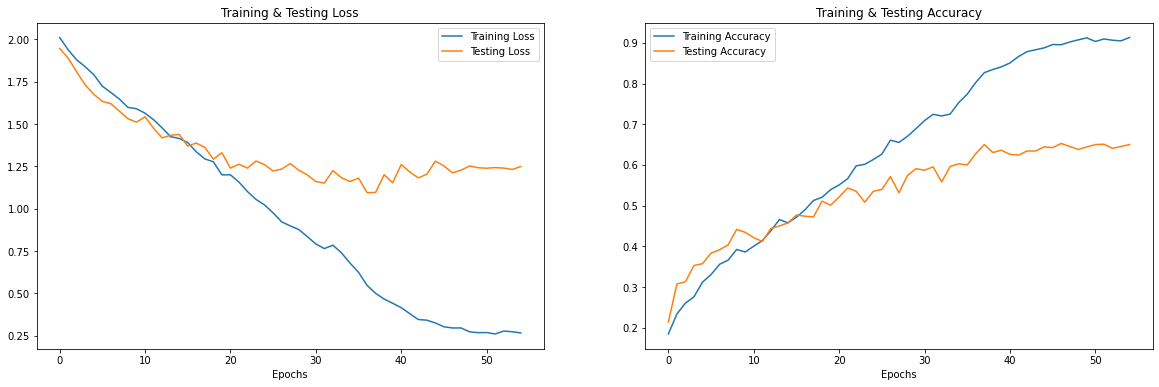

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(55)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [ ]:
# # Save model and weights
# model_name = 'Final_sprint1_Emotion_Model.h5'
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# # save_dir = "/content/drive/emotion_model"

# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Save model and weights at %s ' % model_path)

# # Save the model to disk
# model_json = model.to_json()
# with open("model_json.json", "w") as json_file:
#     json_file.write(model_json)


In [ ]:
model_name = 'Final_sprint1_Emotion_Model.h5'
save_dir = '/content/drive/My Drive/SAS_Sprint1_EmotionDetection'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_json = model.to_json()
with open("/content/drive/My Drive/SAS_Sprint1_EmotionDetection/Final_sprint1_Emotion_Model_json.json", "w") as json_file:
    json_file.write(model_json)



Saved trained model at /content/drive/My Drive/SAS_Sprint1_EmotionDetection/Final_sprint1_Emotion_Model.h5 


In [8]:
loaded_model = keras.models.load_model('/content/drive/My Drive/SAS_Sprint1_EmotionDetection/Final_sprint1_Emotion_Model.h5')
loaded_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 162, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 81, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 81, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 41, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 128)           0

In [21]:
# predicting on test data.
pred_test = loaded_model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)


In [23]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)


,Predicted Labels,Actual Labels
0,angry,angry
1,fear,neutral
2,happy,happy
3,happy,angry
4,calm,neutral
5,surprise,surprise
6,sad,sad
7,neutral,neutral
8,happy,disgust
9,disgust,disgust


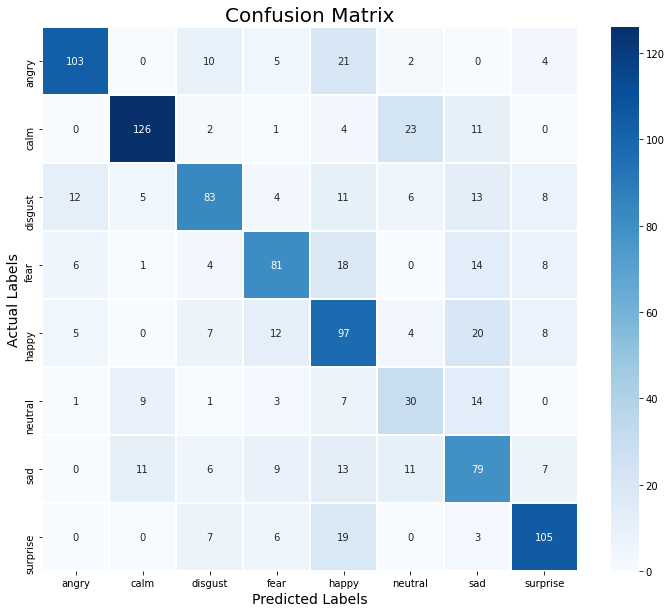

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()